In [2]:
import pandas as pd
import numpy as np
from utilities import read_capice_output, perform_stats, calc_z_scores
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt
import json

In [47]:
data = read_capice_output('./datafiles/test_results.txt.gz')
data

,GeneName,Consequence,PHRED,probabilities,prediction,combined_prediction,chr,pos,ref,alt
0,MSH2,FRAME_SHIFT,34.000,0.999988,Pathogenic,Pathogenic,2,47639582,AGAAA,TAAT
1,BRCA1,FRAME_SHIFT,22.000,0.999986,Pathogenic,Pathogenic,17,41245330,CTTTA,TTT
2,BRCA1,STOP_GAINED,34.000,0.999983,Pathogenic,Pathogenic,17,41243705,CTGAG,GCCT
3,BRCA2,FRAME_SHIFT,17.090,0.999981,Pathogenic,Pathogenic,13,32906819,GG,G
4,BRCA2,FRAME_SHIFT,22.300,0.999981,Pathogenic,Pathogenic,13,32913009,TC,T
...,...,...,...,...,...,...,...,...,...,...
10837,MIR548AZ,NON_SYNONYMOUS,5.220,0.000002,Neutral,Neutral,14,64593063,G,A
10838,LOC100289580,UPSTREAM,1.856,0.000002,Neutral,Neutral,16,88798720,G,A
10839,MYHAS,DOWNSTREAM,0.035,0.000002,Neutral,Neutral,17,10442488,G,A
10840,MIR548AZ,NON_SYNONYMOUS,1.347,0.000001,Neutral,Neutral,14,64519932,A,G


In [48]:
rename = {'#Chrom':'chr','Pos':'pos','Ref':'ref','Alt':'alt'}
usecols = []
for key in rename.keys():
    usecols.append(key)
usecols.append('binarized_label')
test_input = pd.read_csv('./datafiles/test.txt.gz', sep='\t', low_memory=False, usecols=usecols)
test_input.rename(columns=rename, inplace=True)
data.rename(columns={'GeneName':'gene'}, inplace=True)
merge = data.merge(test_input)
merge

,gene,Consequence,PHRED,probabilities,prediction,combined_prediction,chr,pos,ref,alt,binarized_label
0,MSH2,FRAME_SHIFT,34.000,0.999988,Pathogenic,Pathogenic,2,47639582,AGAAA,TAAT,1
1,BRCA1,FRAME_SHIFT,22.000,0.999986,Pathogenic,Pathogenic,17,41245330,CTTTA,TTT,1
2,BRCA1,STOP_GAINED,34.000,0.999983,Pathogenic,Pathogenic,17,41243705,CTGAG,GCCT,1
3,BRCA2,FRAME_SHIFT,17.090,0.999981,Pathogenic,Pathogenic,13,32906819,GG,G,1
4,BRCA2,FRAME_SHIFT,22.300,0.999981,Pathogenic,Pathogenic,13,32913009,TC,T,1
...,...,...,...,...,...,...,...,...,...,...,...
10837,MIR548AZ,NON_SYNONYMOUS,5.220,0.000002,Neutral,Neutral,14,64593063,G,A,0
10838,LOC100289580,UPSTREAM,1.856,0.000002,Neutral,Neutral,16,88798720,G,A,0
10839,MYHAS,DOWNSTREAM,0.035,0.000002,Neutral,Neutral,17,10442488,G,A,0
10840,MIR548AZ,NON_SYNONYMOUS,1.347,0.000001,Neutral,Neutral,14,64519932,A,G,0


In [46]:
output_df = pd.DataFrame(columns=['gene', 'auc', 'n_tot', 'n_benign', 'n_malign'])
# output_df = pd.read_csv('../../../shared/optimal_f1_full_ds_v2.csv', low_memory=False)
# output_df.rename(columns={'default_auc':'auc'}, inplace=True)

In [49]:
for gene in merge['gene'].unique():
    subset = merge[merge['gene'] == gene]
    if subset['binarized_label'].unique().size > 1:
        n_benign = subset[subset['binarized_label'] == 0].shape[0]
        n_malign = subset[subset['binarized_label'] == 1].shape[0]
        n_tot = n_benign + n_malign
        y_true = np.array(subset['binarized_label'])
        y_score = np.array(subset['probabilities'])
        auc = roc_auc_score(y_true=y_true, y_score=y_score)
        output_df = output_df.append(
            pd.DataFrame(
                {
                    'gene':gene,
                    'auc':auc,
                    'n_tot':n_tot,
                    'n_benign':n_benign,
                    'n_malign':n_malign
                }, index=[0]   
            ), ignore_index=False
        )


In [50]:
for column in ['n_tot','n_benign','n_malign']:
    output_df[column] = output_df[column].astype(np.int64)

In [57]:
print(f'The original dataset amount of variants: {data.shape[0]}')
print(f'The amount of variants within the test set that an AUC could be calculated on: {output_df["n_tot"].sum()}')
print(f'The amount of genes that an AUC could be calculated on: {output_df["gene"].unique().size}')

The original dataset amount of variants: 10842
The amount of variants within the test set that an AUC could be calculated on: 5103
The amount of genes that an AUC could be calculated on: 321


In [51]:
# for column in ['auc','n_tot','n_benign','n_malign']:
#     output_df[column] = calc_z_scores(output_df[column])
tot = calc_z_scores(output_df[['auc','n_tot']].sort_values(by='n_tot', ascending=False))
tot

,auc,n_tot
0,0.910010,12.300743
0,0.919209,10.250942
0,0.170257,4.364814
0,0.720996,2.935594
0,-0.311393,2.653512
...,...,...
0,-2.144092,-0.261344
0,-2.144092,-0.261344
0,0.919209,-0.261344
0,0.919209,-0.261344


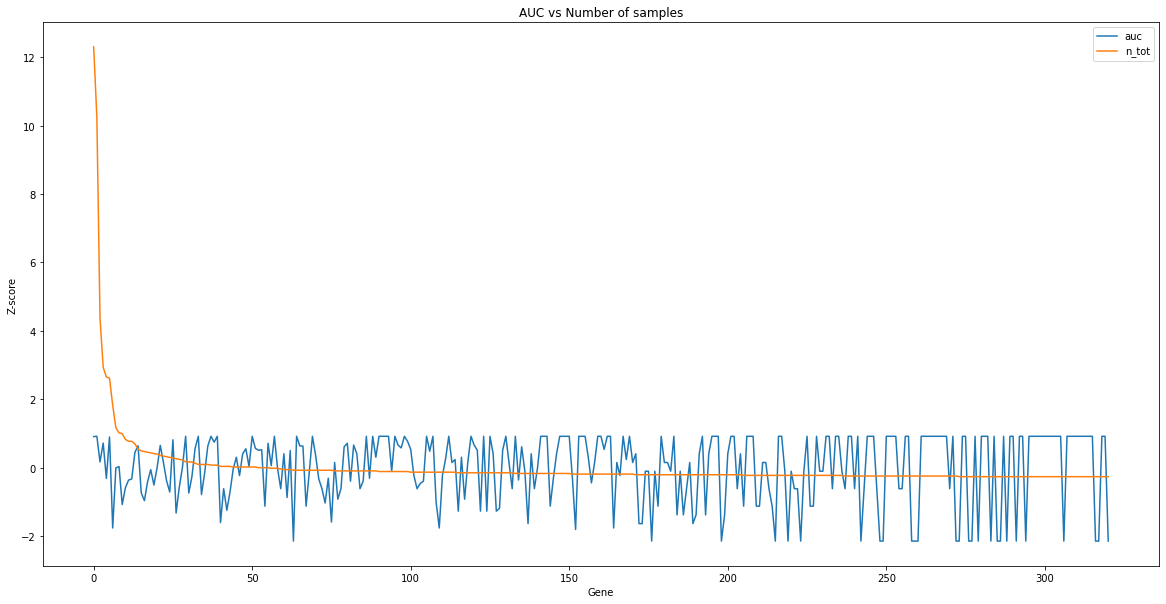

X is likely not normally distributed.
Y is likely not normally distributed.
The Kolmogorov-Smirnov test p-value: 3.690255281714354e-31
The Wilcoxon test p-value: 0.07047092487634633
The Pearson correlation: 0.06084872523872347,
p-value: 0.2770593150917949


In [52]:
plot1 = tot
plot1.index = np.arange(tot.shape[0])
plot1.plot(figsize=(20,10))
plt.xlabel('Gene')
plt.ylabel('Z-score')
plt.title('AUC vs Number of samples')
plt.show()

perform_stats(plot1['auc'],plot1['n_tot'])

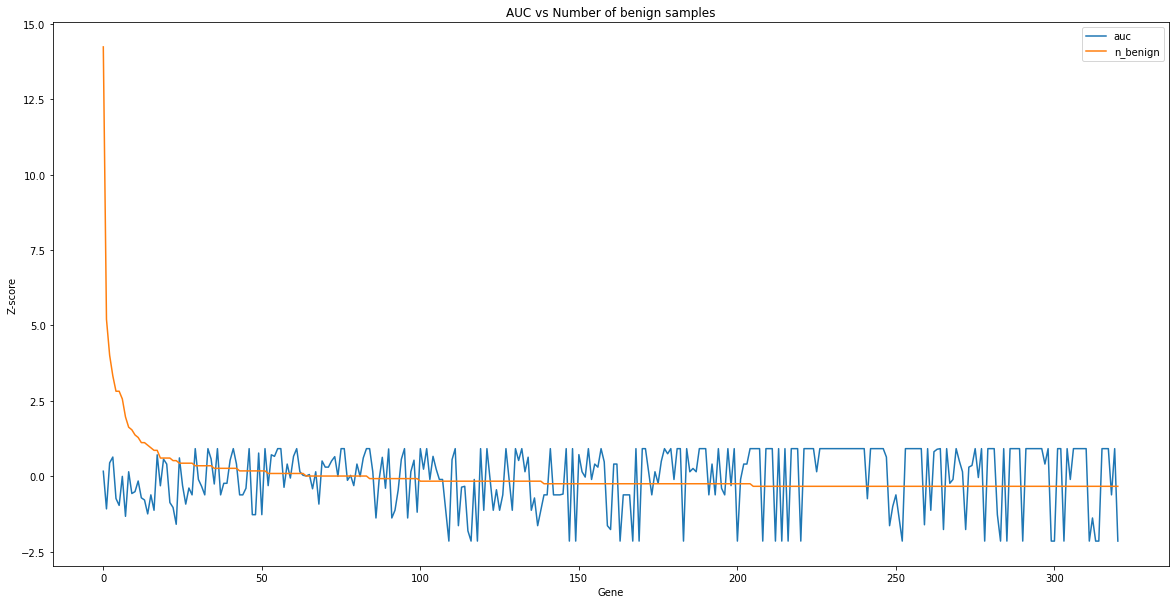

X is likely not normally distributed.
Y is likely not normally distributed.
The Kolmogorov-Smirnov test p-value: 6.384444372456263e-24
The Wilcoxon test p-value: 0.17749409348845513
The Pearson correlation: -0.05398685041319187,
p-value: 0.33495371637669


In [58]:
benign = calc_z_scores(output_df[['auc','n_benign']].sort_values(by='n_benign', ascending=False))

plot1 = benign
plot1.index = np.arange(plot1.shape[0])
plot1.plot(figsize=(20,10))
plt.xlabel('Gene')
plt.ylabel('Z-score')
plt.title('AUC vs Number of benign samples')
plt.show()

perform_stats(plot1['auc'],plot1['n_benign'])

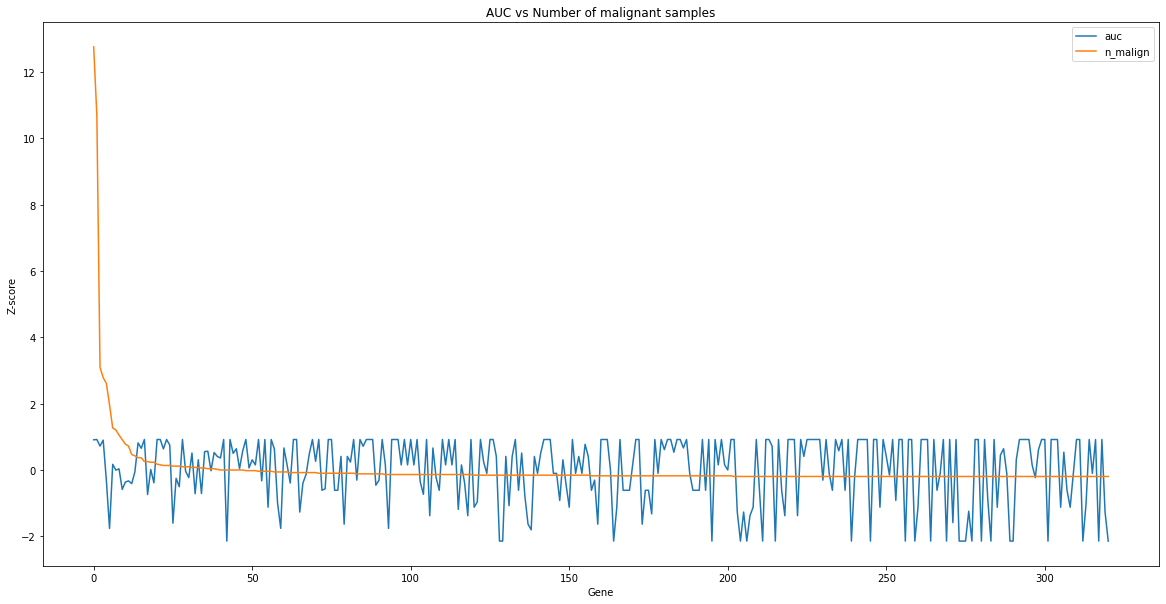

X is likely not normally distributed.
Y is likely not normally distributed.
The Kolmogorov-Smirnov test p-value: 1.1752810468584793e-35
The Wilcoxon test p-value: 0.042067009593066924
The Pearson correlation: 0.07537028360369709,
p-value: 0.17797430086567964


In [59]:
malign = calc_z_scores(output_df[['auc','n_malign']].sort_values(by='n_malign', ascending=False))

plot1 = malign
plot1.index = np.arange(plot1.shape[0])
plot1.plot(figsize=(20,10))
plt.xlabel('Gene')
plt.ylabel('Z-score')
plt.title('AUC vs Number of malignant samples')
plt.show()

perform_stats(plot1['auc'],plot1['n_malign'])

In [23]:
train_file = pd.read_csv('./datafiles/train.txt.gz', sep='\t', low_memory=False)
test_file = pd.read_csv('./datafiles/test.txt.gz', sep='\t', low_memory=False)
train_results = read_capice_output('./datafiles/train_results.txt.gz')

In [24]:
train_file.rename(columns={'#Chrom':'chr','Pos':'pos','Ref':'ref','Alt':'alt'}, inplace=True)
test_file.rename(columns={'#Chrom':'chr','Pos':'pos','Ref':'ref','Alt':'alt'}, inplace=True)
train_file = train_file.merge(train_results[['chr','pos','ref','alt','probabilities']])
test_file = test_file.merge(data[['chr','pos','ref','alt','probabilities']])
merge = train_file.append(test_file, ignore_index=True)
merge['auc'] = np.NaN
merge.rename(columns={'#Chrom':'chr','Pos':'pos','Ref':'ref','Alt':'alt'}, inplace=True)

In [29]:
merge

,chr,Allergy/Immunology/Infectious,alt,AnnoType,Audiologic/Otolaryngologic,Biochemical,CCDS,CDSpos,Cardiovascular,ConsDetail,...,source,tOverlapMotifs,targetScan,to_be_deleted,verPhCons,verPhyloP,inTest,sample_weight,probabilities,auc
0,14,False,G,CodingTranscript,False,False,CCDS9787.1,806.0,False,frameshift,...,vkgl,NaN,NaN,False,1.000,5.843,False,1.0,0.988552,NaN
1,20,False,T,CodingTranscript,True,False,CCDS13112.1,1899.0,True,"frameshift,stop_gained",...,vkgl,NaN,NaN,False,1.000,4.670,False,1.0,0.990329,NaN
2,20,False,C,CodingTranscript,True,False,CCDS13112.1,2118.0,True,frameshift,...,vkgl,NaN,NaN,False,1.000,5.043,False,1.0,0.991696,NaN
3,20,False,A,CodingTranscript,True,False,CCDS13112.1,1586.0,True,frameshift,...,vkgl,NaN,NaN,False,1.000,6.221,False,1.0,0.983607,NaN
4,20,False,A,Intergenic,True,False,NaN,NaN,True,downstream,...,vkgl,NaN,NaN,False,1.000,6.368,False,1.0,0.987999,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345438,17,False,A,CodingTranscript,False,False,CCDS42292.1,2709.0,True,synonymous,...,clinvar,NaN,NaN,False,1.000,1.989,NaN,NaN,0.000139,NaN
345439,11,True,T,CodingTranscript,False,False,CCDS7753.1,75.0,True,synonymous,...,clinvar,NaN,NaN,False,0.943,0.189,NaN,NaN,0.069934,NaN
345440,15,False,C,CodingTranscript,False,False,CCDS32232.1,2673.0,True,synonymous,...,clinvar,NaN,NaN,False,0.999,4.269,NaN,NaN,0.909190,NaN
345441,19,True,A,CodingTranscript,False,False,CCDS12366.1,1767.0,False,synonymous,...,clinvar,NaN,NaN,False,0.996,-0.044,NaN,NaN,0.001238,NaN


In [25]:
output_df

,gene,auc,default_f1,default_recall,default_fpr,default_spec,optimal_c,optimal_auc,optimal_f1,optimal_recall,optimal_fpr,optimal_spec,n_tot,n_benign,n_malign
0,RDH12,0.839161,0.833333,0.909091,0.090909,0.909091,0.020,0.839161,0.833333,0.909091,0.090909,0.909091,24,13,11
1,EIF2AK4,0.981481,0.909091,1.000000,0.000000,1.000000,0.020,0.981481,0.909091,1.000000,0.000000,1.000000,32,27,5
2,EIF2AK3,0.966667,0.842105,1.000000,0.000000,1.000000,0.020,0.966667,0.842105,1.000000,0.000000,1.000000,53,45,8
3,PRKAG2,0.981203,0.761905,1.000000,0.000000,1.000000,0.020,0.981203,0.761905,1.000000,0.000000,1.000000,282,266,16
4,JAG1,0.925388,0.928994,0.987421,0.012579,0.987421,0.025,0.937810,0.940120,0.987421,0.012579,0.987421,320,161,159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2802,FLG2,1.000000,1.000000,1.000000,0.000000,1.000000,0.020,1.000000,1.000000,1.000000,0.000000,1.000000,4,3,1
2803,ACOX2,1.000000,1.000000,1.000000,0.000000,1.000000,0.020,1.000000,1.000000,1.000000,0.000000,1.000000,2,1,1
2804,SLITRK4,1.000000,1.000000,1.000000,0.000000,1.000000,0.020,1.000000,1.000000,1.000000,0.000000,1.000000,3,2,1
2805,POGLUT1,1.000000,1.000000,1.000000,0.000000,1.000000,0.020,1.000000,1.000000,1.000000,0.000000,1.000000,2,1,1


In [30]:
for gene in output_df['gene'].unique():
    auc_score = output_df[output_df['gene'] == gene]['auc'].values[0]
    merge.loc[merge[merge['GeneName'] == gene].index, 'auc'] = auc_score

In [31]:
merge

,chr,Allergy/Immunology/Infectious,alt,AnnoType,Audiologic/Otolaryngologic,Biochemical,CCDS,CDSpos,Cardiovascular,ConsDetail,...,source,tOverlapMotifs,targetScan,to_be_deleted,verPhCons,verPhyloP,inTest,sample_weight,probabilities,auc
0,14,False,G,CodingTranscript,False,False,CCDS9787.1,806.0,False,frameshift,...,vkgl,NaN,NaN,False,1.000,5.843,False,1.0,0.988552,0.839161
1,20,False,T,CodingTranscript,True,False,CCDS13112.1,1899.0,True,"frameshift,stop_gained",...,vkgl,NaN,NaN,False,1.000,4.670,False,1.0,0.990329,0.925388
2,20,False,C,CodingTranscript,True,False,CCDS13112.1,2118.0,True,frameshift,...,vkgl,NaN,NaN,False,1.000,5.043,False,1.0,0.991696,0.925388
3,20,False,A,CodingTranscript,True,False,CCDS13112.1,1586.0,True,frameshift,...,vkgl,NaN,NaN,False,1.000,6.221,False,1.0,0.983607,0.925388
4,20,False,A,Intergenic,True,False,NaN,NaN,True,downstream,...,vkgl,NaN,NaN,False,1.000,6.368,False,1.0,0.987999,0.925388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345438,17,False,A,CodingTranscript,False,False,CCDS42292.1,2709.0,True,synonymous,...,clinvar,NaN,NaN,False,1.000,1.989,NaN,NaN,0.000139,0.915487
345439,11,True,T,CodingTranscript,False,False,CCDS7753.1,75.0,True,synonymous,...,clinvar,NaN,NaN,False,0.943,0.189,NaN,NaN,0.069934,0.940811
345440,15,False,C,CodingTranscript,False,False,CCDS32232.1,2673.0,True,synonymous,...,clinvar,NaN,NaN,False,0.999,4.269,NaN,NaN,0.909190,0.901270
345441,19,True,A,CodingTranscript,False,False,CCDS12366.1,1767.0,False,synonymous,...,clinvar,NaN,NaN,False,0.996,-0.044,NaN,NaN,0.001238,0.898897


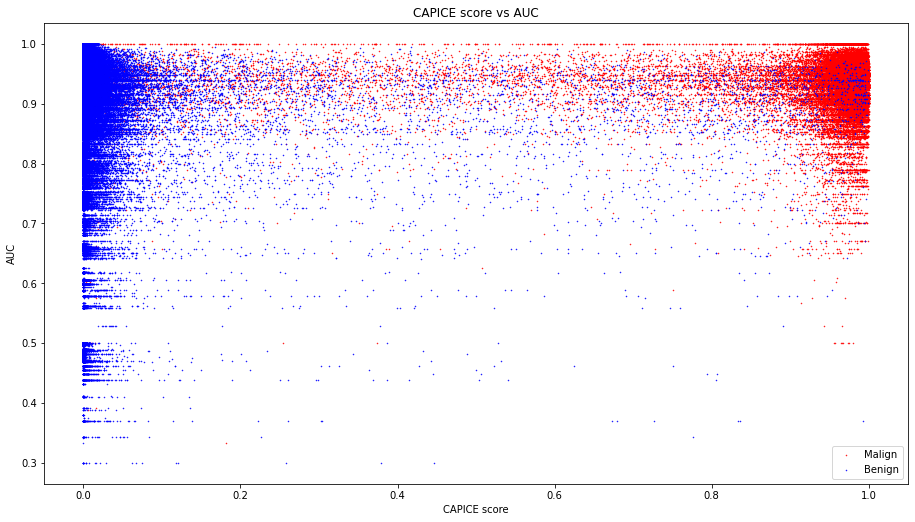

In [45]:
fig = plt.figure(figsize=(15,8))
axes = fig.add_axes([0.1,0.1,0.8,0.8])

axes.scatter(
    merge[merge['binarized_label'] == 1]['probabilities'],
    merge[merge['binarized_label'] == 1]['auc'],
    c='red',
    label='Malign',
    s=1,
    marker='.'
)
axes.scatter(
    merge[merge['binarized_label'] == 0]['probabilities'],
    merge[merge['binarized_label'] == 0]['auc'],
    c='blue',
    label='Benign',
    s=1,
    marker='.'
)
axes.set_xlabel('CAPICE score')
axes.set_ylabel('AUC')
axes.set_title('CAPICE score vs AUC')
axes.legend()
plt.show()

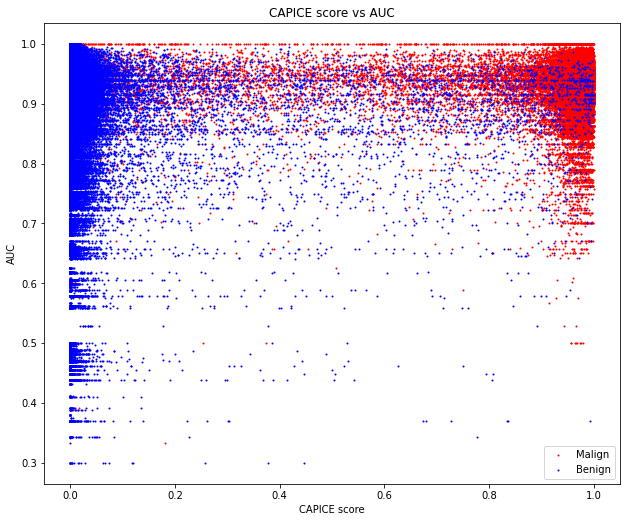

In [36]:
fig = plt.figure(figsize=(10,8))
axes = fig.add_axes([0.1,0.1,0.8,0.8])

p.scatter(
    merge[merge['binarized_label'] == 1]['probabilities'],
    merge[merge['binarized_label'] == 1]['auc'],
    c='red',
    label='Malign',
    s=1
)
axes.scatter(
    merge[merge['binarized_label'] == 0]['probabilities'],
    merge[merge['binarized_label'] == 0]['auc'],
    c='blue',
    label='Benign',
    s=1
)
axes.set_xlabel('CAPICE score')
axes.set_ylabel('AUC')
axes.set_title('CAPICE score vs AUC')
axes.legend()
plt.show()

In [61]:
training_data = pd.read_csv('./datafiles/train.txt.gz', sep='\t', low_memory=False)

In [67]:
output_df = pd.read_csv('../../../shared/optimal_f1_full_ds_v2.csv', low_memory=False)
print(f"Total genes in AUC data: {output_df['gene'].unique().size}, over {output_df['n_tot'].sum()} variants.")

Total genes in AUC data: 2807, over 303911 variants.


In [95]:
data = pd.read_csv('./not_saving_directory/auc_analysis_model1.csv', low_memory=False, index_col=0)
with open('umcg_genepanels.json', 'r') as json_file:
    genepanels = json.load(json_file)
logn = []
for key, value in genepanels['Neurogenetica'].items():
    for gene in value:
        if gene not in logn:
            logn.append(gene)

logc = []
for key, value in genepanels['Hart- en vaatziekten'].items():
    for gene in value:
        if gene not in logc:
            logc.append(gene)

aucs_neuro = np.array(data[data['gene'].isin(logn)]['auc'])
aucs_heart = np.array(data[data['gene'].isin(logc)]['auc'])
from scipy import stats
stats.ttest_ind(aucs_neuro, aucs_heart)

Ttest_indResult(statistic=0.6787288764977482, pvalue=0.4990708099455091)

In [88]:
genepanels.keys()

dict_keys(['5GPM', 'Neurogenetica', 'Amyloidose', 'Hart- en vaatziekten', 'Primaire Immuundeficiëntie', 'Huidziekten', 'Epilepsie', 'Angio-Oedeem', 'Metabole & Leverziekten', 'Hyper-/ hypofosfatemie', 'Mitochondriele aandoeningen', 'Fertiliteit', 'Aangeboren hartafwijkingen', 'Erfelijke Kanker', 'Cardiomyopathie bij kinderen', 'Noonan syndroom', 'Primaire Cilliare Dyskinesie', 'Ontwikkelingsachterstand (OA)', 'Leukemie-Lymfoom'])

In [96]:
cadd_features = ['Ref', 'Alt', 'Type',
                         'Length', 'GC', 'CpG', 'motifECount',
                         'motifEScoreChng', 'motifEHIPos',
                         'oAA', 'nAA', 'cDNApos', 'relcDNApos',
                         'CDSpos', 'relCDSpos',
                         'protPos', 'relProtPos', 'Domain',
                         'Dst2Splice',
                         'Dst2SplType', 'minDistTSS', 'minDistTSE',
                         'SIFTcat', 'SIFTval',
                         'PolyPhenCat', 'PolyPhenVal', 'priPhCons',
                         'mamPhCons', 'verPhCons', 'priPhyloP',
                         'mamPhyloP', 'verPhyloP',
                         'bStatistic', 'targetScan', 'mirSVR-Score',
                         'mirSVR-E', 'mirSVR-Aln', 'cHmmTssA',
                         'cHmmTssAFlnk', 'cHmmTxFlnk',
                         'cHmmTx', 'cHmmTxWk', 'cHmmEnhG',
                         'cHmmEnh', 'cHmmZnfRpts', 'cHmmHet',
                         'cHmmTssBiv', 'cHmmBivFlnk',
                         'cHmmEnhBiv', 'cHmmReprPC', 'cHmmReprPCWk',
                         'cHmmQuies', 'GerpRS', 'GerpRSpval', 'GerpN',
                         'GerpS', 'TFBS',
                         'TFBSPeaks', 'TFBSPeaksMax', 'tOverlapMotifs',
                         'motifDist', 'Segway', 'EncH3K27Ac',
                         'EncH3K4Me1', 'EncH3K4Me3',
                         'EncExp', 'EncNucleo', 'EncOCC',
                         'EncOCCombPVal',
                         'EncOCDNasePVal', 'EncOCFairePVal',
                         'EncOCpolIIPVal',
                         'EncOCctcfPVal', 'EncOCmycPVal',
                         'EncOCDNaseSig',
                         'EncOCFaireSig', 'EncOCpolIISig',
                         'EncOCctcfSig', 'EncOCmycSig',
                         'Grantham', 'Dist2Mutation', 'Freq100bp',
                         'Rare100bp', 'Sngl100bp', 'Freq1000bp',
                         'Rare1000bp', 'Sngl1000bp',
                         'Freq10000bp', 'Rare10000bp',
                         'Sngl10000bp', 'dbscSNV-ada_score',
                         'dbscSNV-rf_score']
len(cadd_features)

92

In [4]:
from scipy.stats import spearmanr
x = np.arange(0,1, 0.01)
y = np.arange(0,1, 0.01)
spearmanr(x,y)

SpearmanrResult(correlation=0.9999999999999999, pvalue=0.0)